# MNIST GAN (adapted from a tutorial from Tensorflow)

In [1]:
# To generate GIFs
!pip install imageio

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
!pip freeze > requirements.txt

In [ ]:
dataset, metadata = tfds.load('cycle_gan/apple2orange', with_info=True, as_supervised=True)
train_apples, train_oranges = dataset['trainA'], dataset['trainB']
test_apples, test_oranges = dataset['testA'], dataset['testB']
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
print(train_apples)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteT3D3JW/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteT3D3JW/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteT3D3JW/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteT3D3JW/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0. Subsequent calls will reuse this data.
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [ ]:
print(metadata)

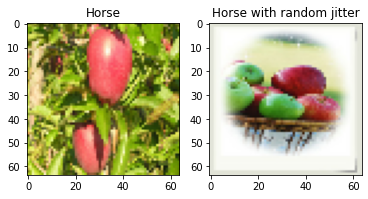

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
train_horses = dataset['trainA']
def normalize_img(image, label):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  image = tf.image.resize(image, [64, 64])
  return image

train_horses = train_horses.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

sample_horse = next(iter(train_horses))
plt.subplot(121)
plt.title('Apple1')
plt.imshow(sample_horse[0] * 0.5 + 0.5)
sample_horse = next(iter(train_horses))
plt.subplot(122)
plt.title('Apple2')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 16)
    #assert model.output_shape == (None, 128, 128, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

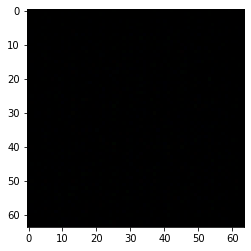

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
#noise = tf.random.uniform([1, 100], 0, 1)
#print('noise', noise)
# sanity check
generated_image = generator(noise, training=False)
#print('generated', generated_image)
plt.imshow(tf.squeeze(generated_image, axis=0)) #, cmap='gray')

In [ ]:
# discriminator is just a simple classifier
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
# sanity check
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00124246]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 205
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

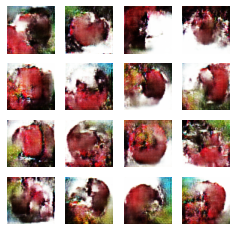

In [ ]:
train(train_horses, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
import glob
from PIL import Image

# filepaths
fp_in = "image_at_epoch*.png"
fp_out = "image.gif"
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

ValueError: ignored